## Imports / load data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from random import choice, randint
from revert.models import ConvNet, Module
from torch.nn.functional import softmax
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter

In [2]:
data = torch.load("../scripts-pcmri/pcmri_tensor.pt")
flows = data["flows"]
print("Shape:", flows.shape)

Shape: torch.Size([991, 6, 32])


## Shift tests

This part should not be used anymore

In [6]:
def roll_test(signal, shift):
    return torch.roll(signal, shift)

In [7]:
test_sig = torch.Tensor(flows[0][0])
print(test_sig)
print(roll_test(test_sig, -5))

tensor([17251.7363, 16945.7520, 16221.2510, 14932.4463, 11781.4043,  8609.6182,
         8626.8408,  9816.2002,  9971.5557,  9845.8447,  8746.4258,  8243.5664,
         7928.6953,  7645.1997,  7038.2383,  6899.6030,  6676.5005,  6583.0698,
         6591.4360,  6541.9272,  6308.8916,  5956.5757,  5537.1719,  5136.6201,
         4786.1133,  5245.1606, 10141.9805, 16769.4805, 18287.0117, 16730.1875,
        16045.1064, 16873.2656])
tensor([ 8609.6182,  8626.8408,  9816.2002,  9971.5557,  9845.8447,  8746.4258,
         8243.5664,  7928.6953,  7645.1997,  7038.2383,  6899.6030,  6676.5005,
         6583.0698,  6591.4360,  6541.9272,  6308.8916,  5956.5757,  5537.1719,
         5136.6201,  4786.1133,  5245.1606, 10141.9805, 16769.4805, 18287.0117,
        16730.1875, 16045.1064, 16873.2656, 17251.7363, 16945.7520, 16221.2510,
        14932.4463, 11781.4043])


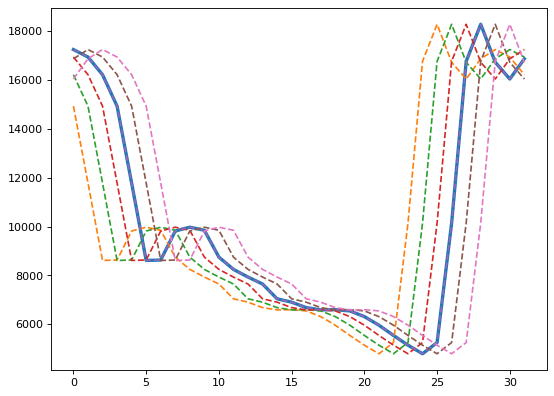

In [8]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(test_sig, linewidth=3)
for i in range(-3, 3):
    plt.plot(roll_test(test_sig, i), linestyle='--')

In [9]:
def rand_shift(channels):
    channel_nb = randint(0, 5)
    shift = choice([i for i in range(-5, 6) if i != 0])
    channels[channel_nb] = torch.roll(channels[channel_nb], shift)
    return channels, channel_nb

def plot_channels(channels):
    for channel in channels:
        plt.plot(channel)

def plot_side_by_side(channels1, channels2):
    plt.figure(figsize=(20, 6), dpi=70)
    plt.subplot(1, 2, 1)
    plot_channels(channels1)
    plt.subplot(1, 2, 2)
    plot_channels(channels2)

tensor([10135.1738, 10329.0273, 10651.2100, 10820.4424, 10921.6641, 10884.2080,
        10678.4141, 10534.4033, 10709.0967, 10646.9229, 10685.9834, 10825.9033,
        10397.8076, 10289.8408, 10082.3984,  9872.0098,  9779.8232,  9512.8193,
         9690.5566,  9588.9170,  9198.7793,  8995.3721,  9336.4639,  9067.0020,
         8751.0479,  8356.8320,  8443.6133,  8912.7529,  9773.8320, 10010.9941,
        10276.7412, 10769.5664])
tensor([10884.2080, 10678.4141, 10534.4033, 10709.0967, 10646.9229, 10685.9834,
        10825.9033, 10397.8076, 10289.8408, 10082.3984,  9872.0098,  9779.8232,
         9512.8193,  9690.5566,  9588.9170,  9198.7793,  8995.3721,  9336.4639,
         9067.0020,  8751.0479,  8356.8320,  8443.6133,  8912.7529,  9773.8320,
        10010.9941, 10276.7412, 10769.5664, 10135.1738, 10329.0273, 10651.2100,
        10820.4424, 10921.6641])


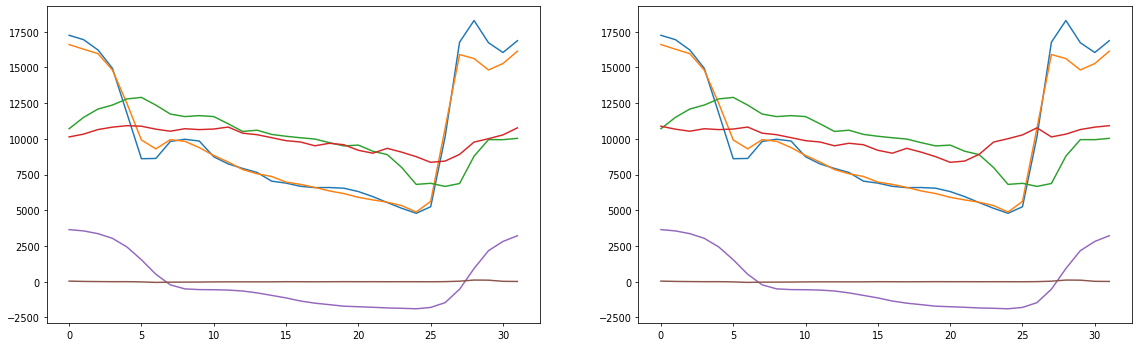

In [10]:
x0 = flows[0].detach().clone()
x, channel_nb = rand_shift(x0)
print(flows[0][channel_nb])
print(x[channel_nb])
plot_side_by_side(flows[0], x)

## ConvNet

In [11]:
print(flows.shape) # All patients
print(flows[0].shape) # 1 patient
print(flows[0][0].shape) # 1 channel

torch.Size([991, 6, 32])
torch.Size([6, 32])
torch.Size([32])


In [24]:
layers = [[32,   6,  8],
          [16, 6*6,  8],
          [8, 6*16,  8],
          [1, 6*32,  1]]

model = ConvNet(layers)
print(model)

ConvNet(
  (dropout): Dropout(p=0.0, inplace=False)
  (conv0): Conv1d(6, 36, kernel_size=(8,), stride=(1,), padding=same, padding_mode=circular)
  (pool0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv1d(36, 96, kernel_size=(8,), stride=(1,), padding=same, padding_mode=circular)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(96, 192, kernel_size=(8,), stride=(1,), padding=same, padding_mode=circular)
  (pool2): MaxPool1d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
)


In [25]:
x0 = flows[0].detach().clone()
x, channel_nb = rand_shift(x0)
print("Channel shifted:", channel_nb)
y = model(x.unsqueeze_(0)).view([6, 32])
p_shift = torch.softmax(y, dim=1)
print(p_shift)

Channel shifted: 3
tensor([[0.0327, 0.0314, 0.0275, 0.0258, 0.0327, 0.0377, 0.0337, 0.0348, 0.0227,
         0.0434, 0.0235, 0.0331, 0.0311, 0.0357, 0.0270, 0.0365, 0.0333, 0.0302,
         0.0194, 0.0398, 0.0387, 0.0429, 0.0387, 0.0373, 0.0303, 0.0271, 0.0219,
         0.0341, 0.0259, 0.0278, 0.0208, 0.0225],
        [0.0365, 0.0223, 0.0406, 0.0268, 0.0436, 0.0358, 0.0281, 0.0435, 0.0361,
         0.0236, 0.0458, 0.0367, 0.0227, 0.0203, 0.0307, 0.0252, 0.0294, 0.0269,
         0.0199, 0.0264, 0.0254, 0.0365, 0.0273, 0.0269, 0.0391, 0.0306, 0.0457,
         0.0290, 0.0329, 0.0358, 0.0223, 0.0274],
        [0.0316, 0.0402, 0.0314, 0.0304, 0.0288, 0.0295, 0.0246, 0.0390, 0.0334,
         0.0407, 0.0252, 0.0374, 0.0249, 0.0291, 0.0187, 0.0384, 0.0305, 0.0342,
         0.0277, 0.0391, 0.0265, 0.0240, 0.0346, 0.0332, 0.0483, 0.0297, 0.0288,
         0.0237, 0.0321, 0.0213, 0.0360, 0.0271],
        [0.0322, 0.0369, 0.0219, 0.0292, 0.0420, 0.0350, 0.0393, 0.0370, 0.0274,
         0.0261, 0.03

#### Test temp ConvNet Sequential

In [48]:
layers = [[1, 6*32, 1],
          [1,    6, 1]]

model2 = ConvNet(layers)
print(model2)

ConvNet(
  (dropout): Dropout(p=0.0, inplace=False)
  (conv0): Conv1d(192, 6, kernel_size=(1,), stride=(1,), padding=same, padding_mode=circular)
  (pool0): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
)


In [52]:
x0 = flows[0].detach().clone()
x, channel_nb = rand_shift(x0)
y = model(x.unsqueeze_(0))
print(y.shape)
print(y.squeeze_(0).shape)
z = model2(y.view([1, 192, 1]))

torch.Size([1, 192])
torch.Size([192])


In [53]:
net = nn.Sequential(model, model2)
print(net)

Sequential(
  (0): ConvNet(
    (dropout): Dropout(p=0.0, inplace=False)
    (conv0): Conv1d(6, 36, kernel_size=(8,), stride=(1,), padding=same, padding_mode=circular)
    (pool0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv1d(36, 96, kernel_size=(8,), stride=(1,), padding=same, padding_mode=circular)
    (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv1d(96, 192, kernel_size=(8,), stride=(1,), padding=same, padding_mode=circular)
    (pool2): MaxPool1d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  )
  (1): ConvNet(
    (dropout): Dropout(p=0.0, inplace=False)
    (conv0): Conv1d(192, 6, kernel_size=(1,), stride=(1,), padding=same, padding_mode=circular)
    (pool0): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
)


In [83]:
test = torch.rand(6,32)
y = net(test.unsqueeze_(0)).view([6, 32])
print(y)

RuntimeError: Given groups=1, weight of size [6, 192, 1], expected input[1, 1, 192] to have 192 channels, but got 1 channels instead

In [61]:
class MyModelA(nn.Module):
    def __init__(self):
        super(MyModelA, self).__init__()
        self.fc1 = nn.Linear(10, 2)
        
    def forward(self, x):
        x = self.fc1(x)
        return x
    

class MyModelB(nn.Module):
    def __init__(self):
        super(MyModelB, self).__init__()
        self.fc1 = nn.Linear(20, 2)
        
    def forward(self, x):
        x = self.fc1(x)
        return x


class MyEnsemble(nn.Module):
    def __init__(self, modelA, modelB):
        super(MyEnsemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.classifier = nn.Linear(4, 2)
        
    def forward(self, x1, x2):
        x1 = self.modelA(x1)
        x2 = self.modelB(x2)
        x = torch.cat((x1, x2.detach()), dim=1)  # Detaching x2, so modelB wont be updated
        x = self.classifier(F.relu(x))
        return x

# Create models and load state_dicts    
modelA = MyModelA()
modelB = MyModelB()

model = MyEnsemble(modelA, modelB)
x1 = torch.randn(1, 10)
x2 = torch.randn(1, 20)
output = model(x1, x2)

## Training

In [13]:
def hshift(x, dim=-1):
    y = torch.tensor([0 for i in range(len(x))])
    nb_chan = torch.randint(0, len(x), (1,))
    half = x.shape[dim] // 2
    shift = torch.randint(-half, half+1, (1,)).item()
    x[nb_chan] = x[nb_chan].roll(-shift, dim)
    y[nb_chan] = shift
    return x, y

In [14]:
# Example
x = flows[0].detach().clone()
print(x)
x2, y = hshift(x)
print(y)
print(x2)

tensor([[ 1.7252e+04,  1.6946e+04,  1.6221e+04,  1.4932e+04,  1.1781e+04,
          8.6096e+03,  8.6268e+03,  9.8162e+03,  9.9716e+03,  9.8458e+03,
          8.7464e+03,  8.2436e+03,  7.9287e+03,  7.6452e+03,  7.0382e+03,
          6.8996e+03,  6.6765e+03,  6.5831e+03,  6.5914e+03,  6.5419e+03,
          6.3089e+03,  5.9566e+03,  5.5372e+03,  5.1366e+03,  4.7861e+03,
          5.2452e+03,  1.0142e+04,  1.6769e+04,  1.8287e+04,  1.6730e+04,
          1.6045e+04,  1.6873e+04],
        [ 1.6603e+04,  1.6279e+04,  1.5966e+04,  1.4810e+04,  1.2477e+04,
          9.9219e+03,  9.2979e+03,  9.9448e+03,  9.8303e+03,  9.3870e+03,
          8.8362e+03,  8.3785e+03,  7.8507e+03,  7.5549e+03,  7.3651e+03,
          6.9739e+03,  6.8108e+03,  6.6001e+03,  6.3533e+03,  6.1669e+03,
          5.9057e+03,  5.7230e+03,  5.5650e+03,  5.3261e+03,  4.8744e+03,
          5.6198e+03,  1.0746e+04,  1.5905e+04,  1.5621e+04,  1.4825e+04,
          1.5274e+04,  1.6138e+04],
        [ 1.0709e+04,  1.1501e+04,  1.20

In [31]:
def shift_one(x, y=None):
    """
        Input:
            - x corresponds to a list of channels
            - y (optional) corresponds to the list of shifts to be applied (only one channel should be shifted)
        Outputs:
            - x corresponds to the same list of channels (with one of them shifted)
            - y corresponds to the list of shifts applied (only one channel should be shifted)
    """
    if x.dim() == 2:
        if y is None:
            y = torch.tensor([0 for _ in range(len(x))])
            nb_chan = torch.randint(0, len(x), (1,))
            half = x.shape[-1] // 2
            shift = torch.randint(-half, half+1, (1,))
            y[nb_chan] = shift.item()
        else:
            for nb_chan, shift in enumerate(y):
                if shift.item() != 0:
                    break
        x[nb_chan] = x[nb_chan].roll(-shift.item(), -1)
        return x, y
    elif x.dim() == 3:
        return torch.stack([shift_one(xi, y) for xi in x])
    else:
        raise TypeError("x must be of shape (N, Nc, Npts) or (Nc, Npts)")

In [32]:
# Test
x = flows[0].detach().clone()
print(x)
x2, y = shift_one(x, torch.tensor([0,2,0,0,0,0]))
print(y)
print(x2)

tensor([[ 1.7252e+04,  1.6946e+04,  1.6221e+04,  1.4932e+04,  1.1781e+04,
          8.6096e+03,  8.6268e+03,  9.8162e+03,  9.9716e+03,  9.8458e+03,
          8.7464e+03,  8.2436e+03,  7.9287e+03,  7.6452e+03,  7.0382e+03,
          6.8996e+03,  6.6765e+03,  6.5831e+03,  6.5914e+03,  6.5419e+03,
          6.3089e+03,  5.9566e+03,  5.5372e+03,  5.1366e+03,  4.7861e+03,
          5.2452e+03,  1.0142e+04,  1.6769e+04,  1.8287e+04,  1.6730e+04,
          1.6045e+04,  1.6873e+04],
        [ 1.6603e+04,  1.6279e+04,  1.5966e+04,  1.4810e+04,  1.2477e+04,
          9.9219e+03,  9.2979e+03,  9.9448e+03,  9.8303e+03,  9.3870e+03,
          8.8362e+03,  8.3785e+03,  7.8507e+03,  7.5549e+03,  7.3651e+03,
          6.9739e+03,  6.8108e+03,  6.6001e+03,  6.3533e+03,  6.1669e+03,
          5.9057e+03,  5.7230e+03,  5.5650e+03,  5.3261e+03,  4.8744e+03,
          5.6198e+03,  1.0746e+04,  1.5905e+04,  1.5621e+04,  1.4825e+04,
          1.5274e+04,  1.6138e+04],
        [ 1.0709e+04,  1.1501e+04,  1.20

In [13]:
# py: sortie du réseau
# y: indice de translation cible
def wasserstein(py, y, N):
    nC = y.shape[-1]
    py = py.view([-1, nC, N])
    Dy = torch.arange(N).repeat(nC).view([nC, N])
    return (py * (Dy - y[:, :, None]).abs()).sum()

model.Npts = 32
model.loss = lambda py, y: wasserstein(py, y, model.Npts)

In [14]:
# N = n_it * n_batchs
# x : (N, 6, 32)
# y : (N, 6)
def data_loader(x, y, batch_size):
    dataset = TensorDataset(x, y)
    # /!\ Paramétrer le DataLoader (num_workers pour speed up le process)
    # Le DataLoader permet d'itérer sur des tuples (xi, yi) où xi.shape[0] = yi.shape[0] = batch_size 
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader

In [15]:
def free(*xs):
    for x in xs: del x
    torch.cuda.empty_cache()
    
def episodes(flows, p=None):
    if p is None:
        p = {'epochs': 25, 'n_batch': 256, 'lr': 1e-3, 'gamma': 0.8, 'n_it': 2} # 'n_it': 3750
    
    N = p['n_batch'] * p['n_it']
    n_chan = flows.shape[-2]
    n_val = flows.shape[-1]
    
    x = []
    y = []
    for i in range(N):
        xi = flows[i % len(flows)].detach().clone()
        x2, y2 = hshift(xi)
        x.append(x2)
        y.append(y2)
    
    x = torch.cat(x).view(N, n_chan, n_val)
    y = torch.cat(y).view(N, n_chan)
    
    print("x shape:", x.shape)
    print("y shape:", y.shape)
    
    #--- data ---
    loader = data_loader(x, y, p['n_it'])
    
    #--- optimizer ---
    optim = Adam(model.parameters(), lr=p['lr'])
    lr = ExponentialLR(optim, gamma=p['gamma'])
    
    model.fit(loader, optim, lr, epochs=p['epochs'], w="Loss/a")
    free(optim, lr)

In [27]:
model.writer = SummaryWriter()
episodes(flows)

x shape: torch.Size([512, 6, 32])
y shape: torch.Size([512, 6])
